In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, TWL, Aggregate_WavesFamilies

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim
from teslakit.plotting.extremes import Plot_ReturnPeriodValidation



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


In [3]:
# --------------------------------------
# Load data for climate emulator fitting: waves partitions and families, KMA, DWT

WVS = db.Load_WAVES_hist()      # Historical gow waves point
KMA = db.Load_ESTELA_KMA()      # ESTELA predictor KMA

# prepare KMA data 
DWTs_fit = xr.Dataset(
    {
        'bmus'       : ('time', KMA['sorted_bmus_storms'].values[:] + 1),
        'cenEOFs'    : (('n_clusters', 'n_features',), KMA['cenEOFs'].values[:]),
    },
    coords = {'time' : KMA['time'].values[:]}
)


# --------------------------------------
# Load data for climate emulator simulation: ESTELA DWT and TCs (MU, TAU) 

DWTs_sim = db.Load_ESTELA_DWT_sim()

TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
TCs_RBFs = db.Load_TCs_sim_r2_rbf_output()  # TCs numerical_IH-RBFs_interpolation output

probs_TCs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
pchange_TCs = probs_TCs['category_change_cumsum'].values[:]

l_mutau_wt = db.Load_MU_TAU_hydrograms()   # MU - TAU intradaily hidrographs for each WWT
MU_WT = np.array([x.MU.values[:] for x in l_mutau_wt])  # MU and TAU numpy arrays
TAU_WT = np.array([x.TAU.values[:] for x in l_mutau_wt])



## Climate Emulator - Fitting

In [4]:
# --------------------------------------
# Climate Emulator extremes model fitting

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)

# Waves and KMA bmus data share time dimension
WVS_fit = WVS.sel(time = DWTs_fit.time)

# Fit extremes model
config = {
    'name_fams':       ['sea', 'swell_1', 'swell_2'],
    'force_empirical': ['sea_Tp'],
}

#CE.FitExtremes(DWTs_fit, WVS_fit, config)

# Load Climate Emulator
CE.Load()

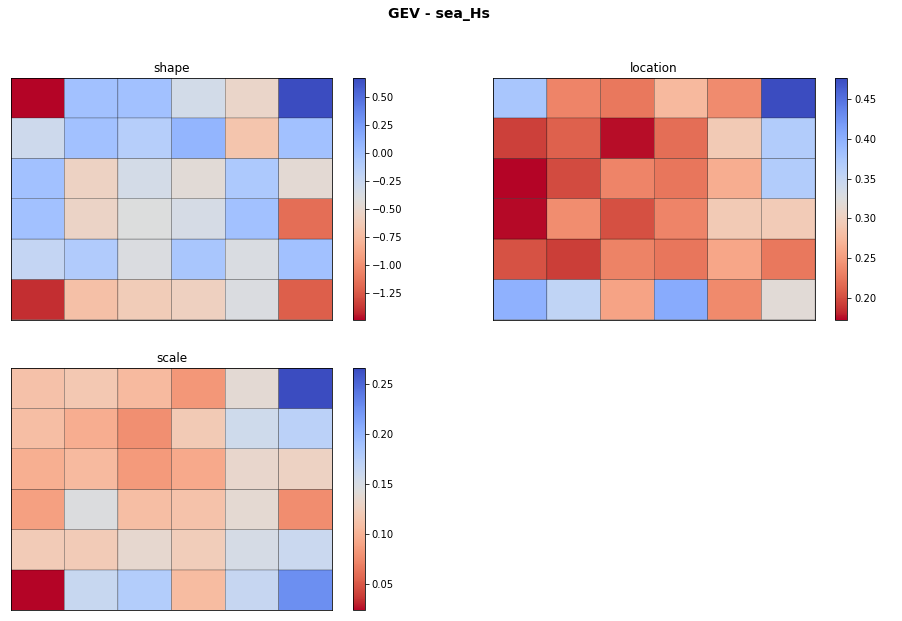

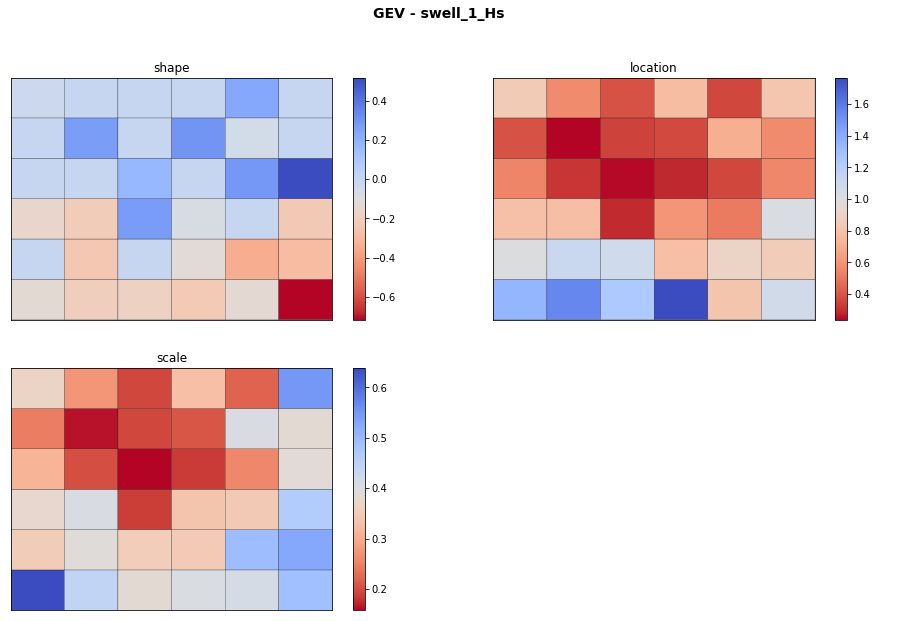

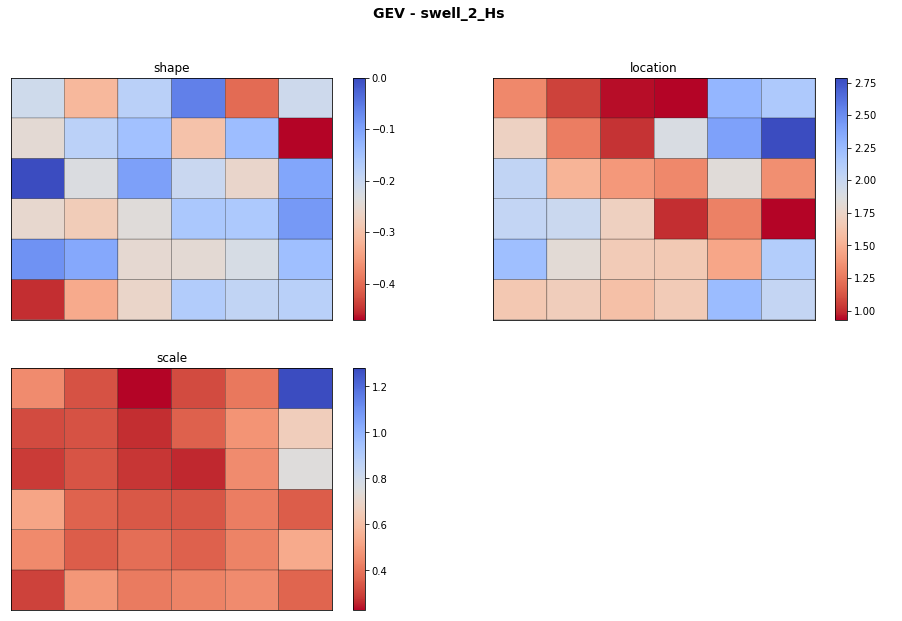

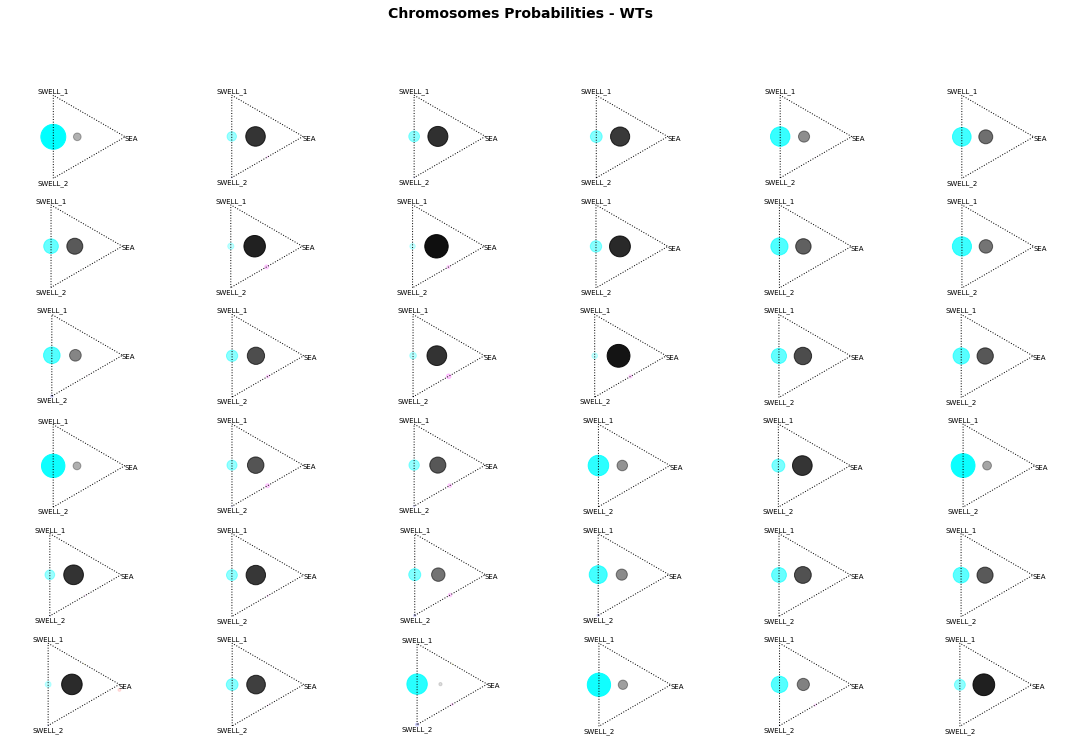

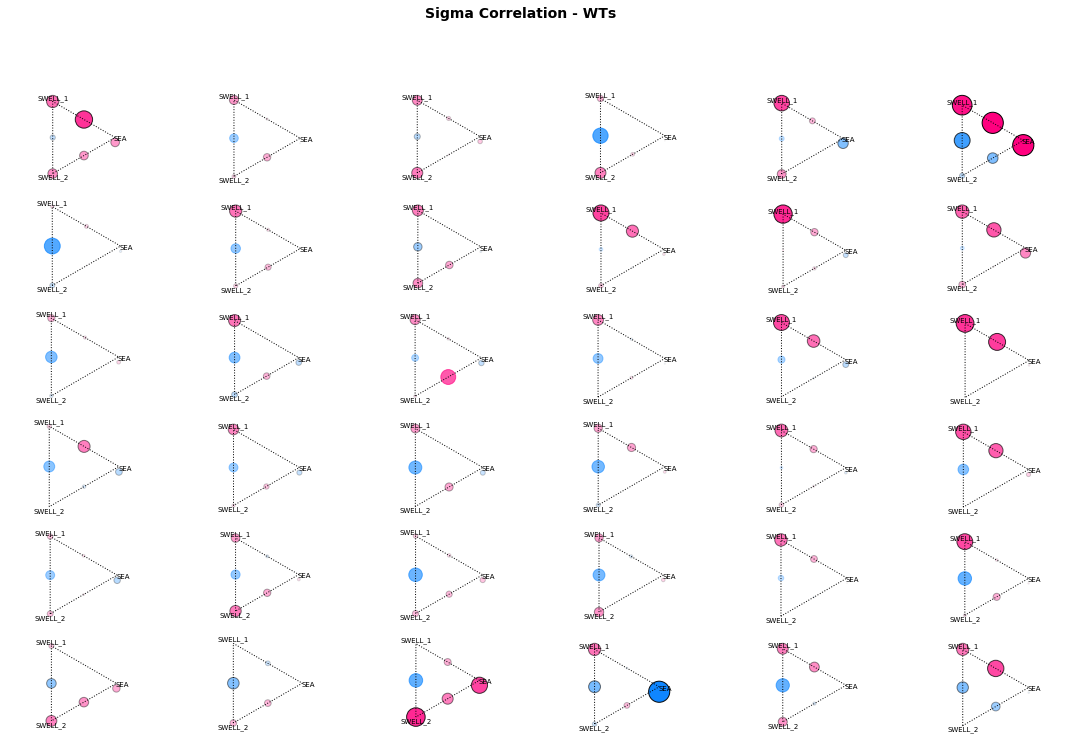

In [5]:
# Fit report figures
CE.Report_Fit();



## Climate Emulator - Simulation

In [6]:
# Select DWT series to simulate
DWTs_sim = DWTs_sim.sel(time=slice('1700-01-01','2700-01-01'), n_sim=0)

print(DWTs_sim)


<xarray.Dataset>
Dimensions:      (time: 365243)
Coordinates:
  * time         (time) object 1700-01-01 00:00:00 ... 2700-01-01 00:00:00
Data variables:
    evbmus_sims  (time) float32 ...


In [7]:
# --------------------------------------
#  Climate Emulator simulation

#ce_sims = 10

# Simulate waves
#WVS_sim = CE.Simulate_Waves(DWTs_sim, ce_sims, filters={'hs':True, 'tp':True, 'ws':True})

# Simulate TCs and update simulated waves
#TCs_sim, WVS_upd = CE.Simulate_TCs(DWTs_sim, TCs_params, TCs_RBFs, pchange_TCs, MU_WT, TAU_WT)


# Load Climate Emulator Simulations
WVS_sim, TCs_sim, WVS_upd = CE.LoadSim()
print(WVS_upd)


<xarray.Dataset>
Dimensions:      (n_sim: 10, time: 98926)
Coordinates:
  * time         (time) object 1700-01-01 00:00:00 ... 2700-01-01 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    DWT          (n_sim, time) float32 ...
    sea_Hs       (n_sim, time) float32 ...
    sea_Tp       (n_sim, time) float32 ...
    sea_Dir      (n_sim, time) float32 ...
    swell_1_Hs   (n_sim, time) float32 ...
    swell_1_Tp   (n_sim, time) float32 ...
    swell_1_Dir  (n_sim, time) float32 ...
    swell_2_Hs   (n_sim, time) float32 ...
    swell_2_Tp   (n_sim, time) float32 ...
    swell_2_Dir  (n_sim, time) float32 ...


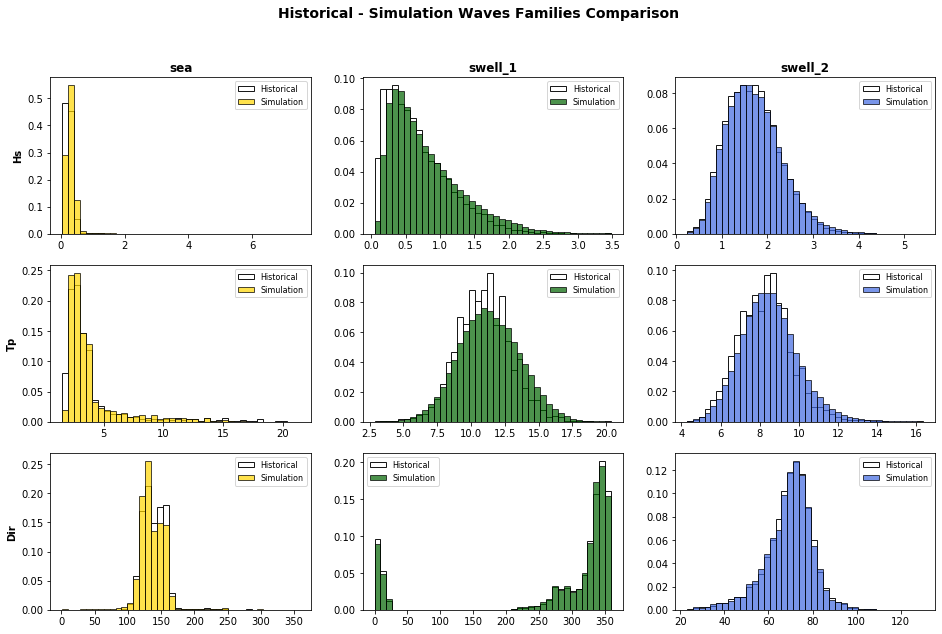

In [8]:
# Plot simulated waves parameters distribution 

Plot_Waves_Histogram_FitSim(WVS_fit, WVS_upd.isel(n_sim=0));
    

In [9]:
# --------------------------------------
#  Aggregate simulated and historical waves data

# aggregate simulation
l_wa = []
for i_sim in WVS_upd.n_sim:
    
    wa = Aggregate_WavesFamilies(WVS_upd.sel(n_sim=i_sim))
    l_wa.append(wa)
    
WVS_sim_a = xr.concat(l_wa, 'n_sim')

# aggregate historical
WVS_hist = Aggregate_WavesFamilies(WVS_fit)

# calculate Atmospheric Water Level
WVS_sim_a['AWL'] = AWL(WVS_sim_a.Hs, WVS_sim_a.Tp)
WVS_hist['AWL'] = AWL(WVS_hist.Hs, WVS_hist.Tp)



## Climate Emulator - Annual Maxima

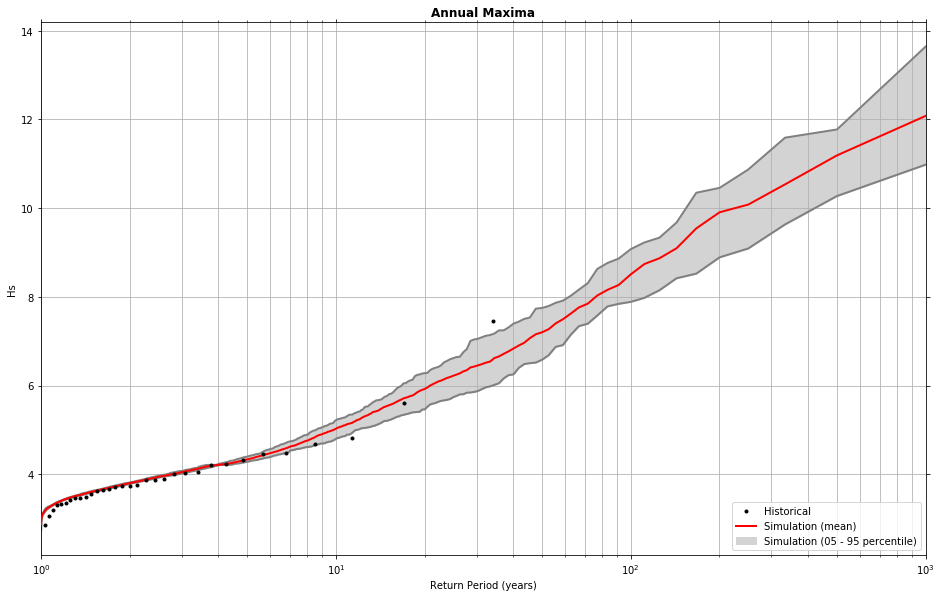

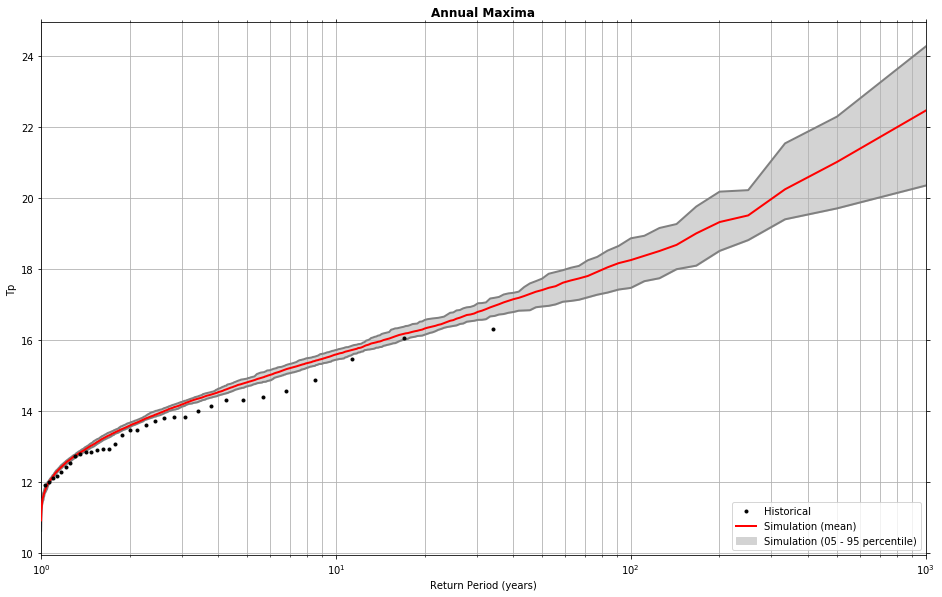

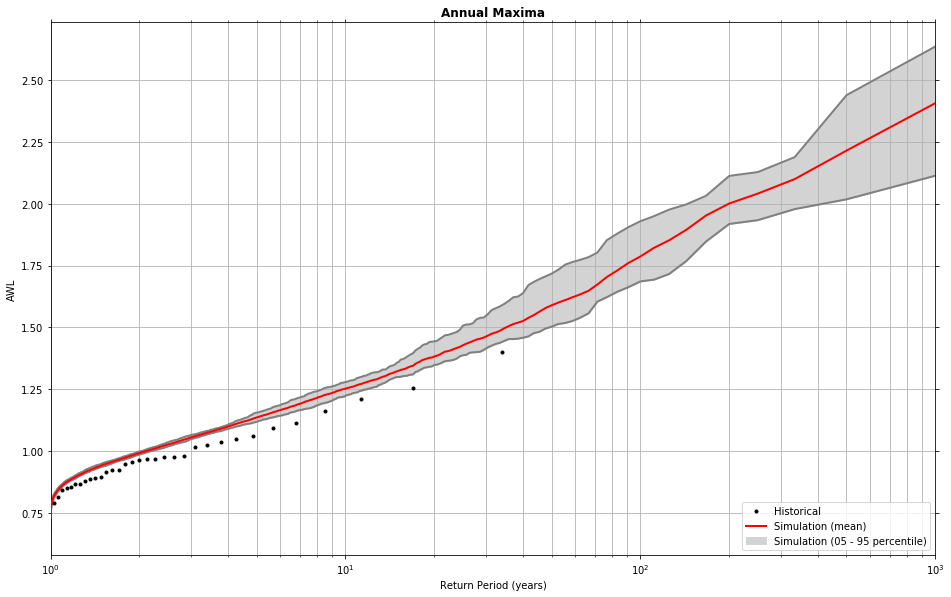

In [10]:
# Annual Maxima: Hs, Tp and AWL
vns = ['Hs', 'Tp', 'AWL']

for vn in vns:
    
    # get annual maxima
    hist_A = WVS_hist[vn].groupby('time.year').max(dim='time')
    sim_A = WVS_sim_a[vn].groupby('time.year').max(dim='time')

    # Return Period historical vs. simulations
    Plot_ReturnPeriodValidation(hist_A, sim_A);
    